In [21]:
import os, sys

# go up one level from the notebook dir
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

print("REPO_ROOT:", REPO_ROOT)

import torch
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.datasets import make_friedman1
import matplotlib.pyplot as plt
import numpy as np
import csv
import math

from src import losses
from src.models import (
    StandardThreeLayerDNN,
    RandomFeatureGaussianProcess,
    ResFFN12_128,
    SNGP_ResFFN12_128,
)
from src.utils import (
    train_model,
    create_moons_data_loaders,
    create_blobs_data_loaders,
    get_data_from_loader,
    apply_bounded_spectral_norm,
    compute_covariance,
)
from src.viz_utils import (
    display_data_splits,
    plot_loss,
    plot_preds,
    plot_probas_over_dense_grid,
    plot_probabilities,
    plot_probabilities_gp,
    plot_thresholded_predictions,
)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(device))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)

REPO_ROOT: /Users/kailashfaris/Desktop/Tufts/cs136 (StatPatt)/project/shanethomaswilliams-sngp-sandbox-179f27b
Using MPS (Apple Metal)
Final device: mps


In [22]:
def write_history_to_csv(csv_path, x_N, y_N):
    N = x_N.size
    data = [["X", "Y"]]
    for i, x in enumerate(x_N):
        data.append([x, y_N[i]])

    with open("data/"+csv_path+".csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [23]:
def write_history_to_csv_multivar(csv_path, x_ND, y_N):
    N = len(x_ND)
    D = len(x_ND[0])
    data_names = [f"X{d}" for d in range(D)] + ["Y"]
    data = np.column_stack((x_ND, y_N))

    with open("data/"+csv_path+".csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(data_names)
        writer.writerows(data)

# Full Regressions

### Linear Regression

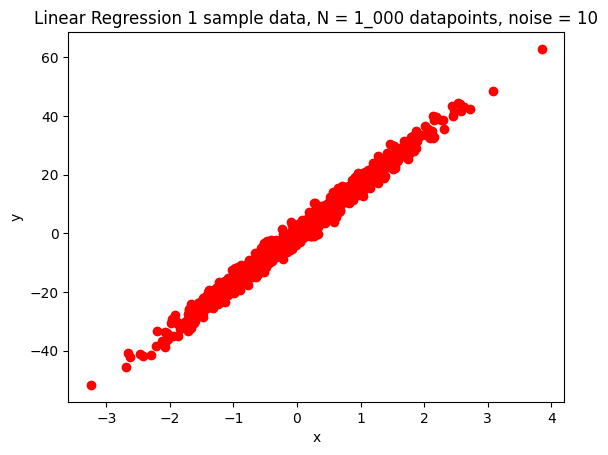

In [24]:
N = 1000
noise = 2
#Note we don't control the equations of these slopes
X, y = make_regression(n_samples=1_000, n_features=1, noise=noise, random_state=42)
#print(X)
#print(y)
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression 1 sample data, N = 1_000 datapoints, noise = 10")
write_history_to_csv("regression_N="+str(N), X, y)

### Sinusoidal

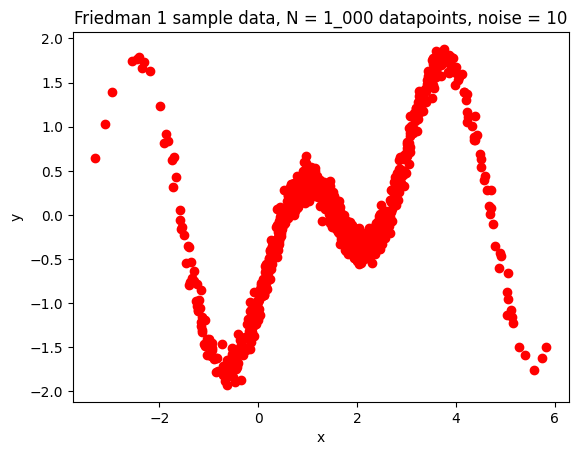

In [25]:
N = 1000
mean = 1.5
stdev = 1.5
noise = 0.1
X = (np.random.normal(loc=mean, scale=stdev, size=N))
#print(X)
y = np.sin(2 * X) - np.cos(X)
y = y + (noise * np.random.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Friedman 1 sample data, N = 1_000 datapoints, noise = 10")
write_history_to_csv("sinusoidal_N="+str(N), X, y)

### Friedman

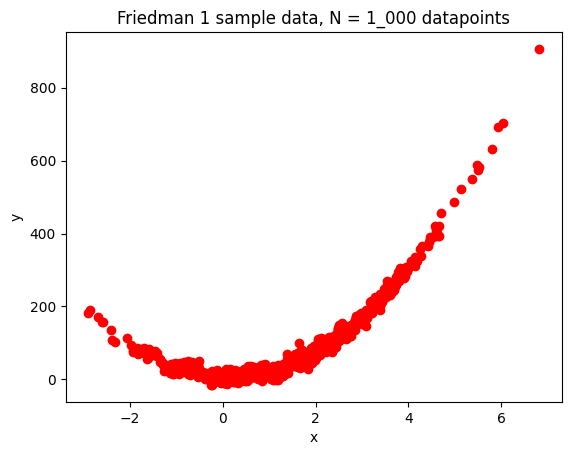

In [26]:
N = 1000
mean = 1.5
stdev = 1.5
noise = 10
X = (np.random.normal(loc=mean, scale=stdev, size=N))
#print(X)
y = 10 * np.sin(np.pi * (X ** 2)) + (20 * ((X - 0.5) ** 2)) + (15 * X)
y = y + (noise * np.random.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Friedman 1 sample data, N = 1_000 datapoints")
write_history_to_csv("friedman_N="+str(N), X, y)

### Friedman 5 variables 

In [27]:
N = 1000
mean = 1.5
stdev = 1.5
noise = 10
num_variables = 5
X, y = make_friedman1(n_samples=N, n_features=5, noise=noise, random_state=42)
#plt.plot(X, y, 'ro')
#plt.xlabel("x")
#plt.ylabel("y")
#plt.title("Friedman 1 sample data, N = 1_000 datapoints")
fileName = "friedman_var="+str(num_variables)+"_N="+str(N)
write_history_to_csv_multivar(fileName, X, y)

# Sparse Regressions

### Linear Regression

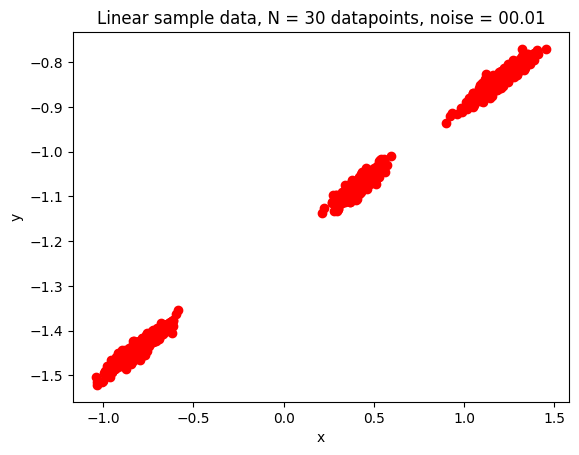

In [28]:
N = 1000
noise = 0.01
split = [0.3, 0.4, 0.3]
X1 = (np.random.normal(loc=-0.8, scale=0.1, size=int(N*split[0])))
X2 = (np.random.normal(loc=0.4, scale=0.07, size=int(N*split[1])))
X3 = (np.random.normal(loc=1.2, scale=0.1, size=int(N*split[2])))
X = np.concatenate((X1, X2, X3))
#print(X)
y = 0.3 * X - 1.2
y = y + (noise * np.random.normal(size = X.size))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear sample data, N = 30 datapoints, noise = 00.01")
write_history_to_csv("regression_sparse_N="+str(N), X, y)

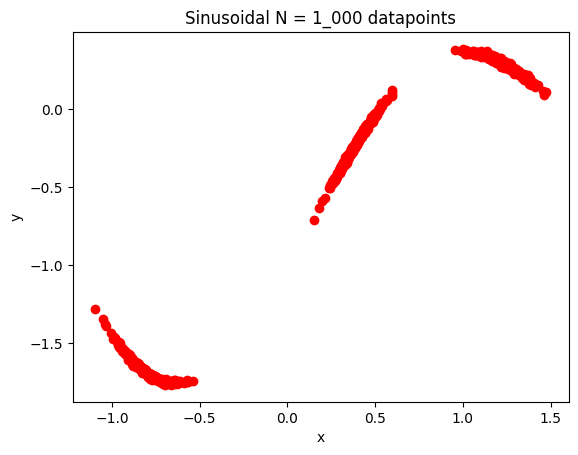

In [29]:
N = 1000
noise = 0.01
split = [0.3, 0.4, 0.3]
X1 = (np.random.normal(loc=-0.8, scale=0.1, size=int(N*split[0])))
X2 = (np.random.normal(loc=0.4, scale=0.07, size=int(N*split[1])))
X3 = (np.random.normal(loc=1.2, scale=0.1, size=int(N*split[2])))
X = np.concatenate((X1, X2, X3))
#print(X)
y = np.sin(2 * X) - np.cos(X)
y = y + (noise * np.random.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sinusoidal N = 1_000 datapoints")
write_history_to_csv("sinusoidal_sparse_N="+str(N), X, y)

### Friedman

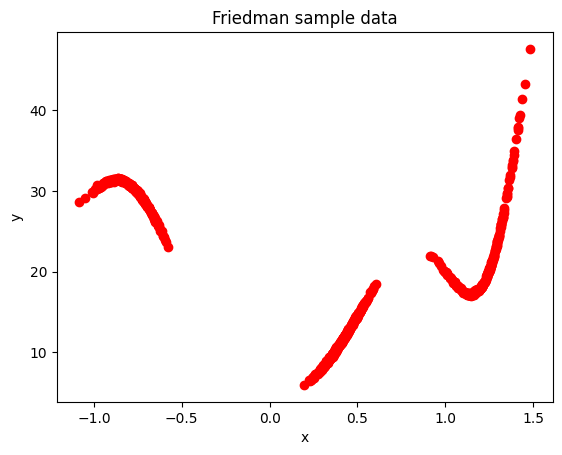

In [30]:
N = 1000
noise = 0.1
split = [0.3, 0.4, 0.3]
X1 = (np.random.normal(loc=-0.8, scale=0.1, size=int(N*split[0])))
X2 = (np.random.normal(loc=0.4, scale=0.07, size=int(N*split[1])))
X3 = (np.random.normal(loc=1.2, scale=0.1, size=int(N*split[2])))
X = np.concatenate((X1, X2, X3))
#print(X)
y = 10 * np.sin(np.pi * (X ** 2)) + (20 * ((X - 0.5) ** 2)) + (15 * X)
y = y + (noise * np.random.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Friedman sample data")
write_history_to_csv("friedman_sparse_N="+str(N), X, y)